# Load packages

In [66]:
from metaspace import SMInstance
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels
import seaborn as sns

import torch
import torch.nn.functional as functional
from deepims_clust import DeepClustering
from deepims_clust.utils import size_adaption, size_adaption_symmetric
from deepims_clust.cnnClust import CNNClust
from deepims_clust.pseudo_labeling import pseudo_labeling, compute_dataset_ublb
from scipy.special import binom

import umap
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper functions

In [69]:
def same_ion_similarity(model):

    # Inference of embeddings
    embeddings = model.predict_embeddings()

    # Compute distance between same ions
    same_similarities = []
    for i in set(model.ill_int):
        if len(embeddings[model.ill_int==i]) > 1:
            a = pairwise_kernels(embeddings[model.ill_int==i], metric='cosine')
            np.fill_diagonal(a, val=0)
            same_similarities.append(a.sum()/(binom(a.shape[0], 2)*2))

    # Compute distance between all Sample N random similarities that are not the same ion
    different_similarities = []
    for i in range(5000):
        samples = np.random.randint(0, high=model.image_data.shape[0], size=2)
        if model_softmax.ill_int[samples[0]] != model.ill_int[samples[1]]:
            a = pairwise_kernels(embeddings[samples], metric='cosine')
            different_similarities.append(a[1,0])

    # Plot distances as violins
    final_df = pd.concat([pd.DataFrame({'type': 'Same ion', 'similarity': same_similarities}), 
                          pd.DataFrame({'type': 'Different ion', 'similarity': different_similarities})])
    sns.violinplot(final_df, x='type', y='similarity')
    plt.show()

# Datasets

In [2]:
evaluation_datasets = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_01h01m06s'
                  ]

In [3]:
training_results = {}
training_images = {}
training_if = {}
polarity = '+'

sm = SMInstance()

for k in evaluation_datasets:
    ds = sm.dataset(id=k)
    results = ds.results(database=("HMDB", "v4"), fdr=0.2).reset_index()
    training_results[k] = results
    tmp = ds.all_annotation_images(fdr=0.2, database=("HMDB", "v4"), only_first_isotope=True)
    onsample = dict(zip(results['formula'].str.cat(results['adduct']), ~results['offSample']))
    formula = [x.formula+x.adduct for x in tmp if onsample[x.formula+x.adduct]]
    tmp = np.array([x._images[0] for x in tmp if onsample[x.formula+x.adduct]])
    training_images[k] = tmp
    training_if[k] = formula

100%|████████████████████████████████████████| 241/241 [00:00<00:00, 258.10it/s]


# Data preprocessing

In [4]:
[x.shape for x in training_images.values()]

[(245, 74, 84),
 (221, 88, 88),
 (194, 41, 78),
 (237, 56, 85),
 (276, 71, 82),
 (201, 35, 55),
 (186, 60, 44)]

In [5]:
padding_images = size_adaption_symmetric(training_images)
[x.shape for x in padding_images.values()]

[(245, 88, 88),
 (221, 88, 88),
 (194, 88, 88),
 (237, 88, 88),
 (276, 88, 88),
 (201, 88, 88),
 (186, 88, 88)]

In [6]:
tst = set(training_if['2022-12-07_02h13m50s']).intersection(set(training_if['2022-12-07_02h13m20s']), 
                                                          set(training_if['2022-12-07_02h10m45s']), 
                                                          set(training_if['2022-12-07_02h09m41s']), 
                                                          set(training_if['2022-12-07_02h08m52s']), 
                                                          set(training_if['2022-12-07_01h02m53s']), 
                                                          set(training_if['2022-12-07_01h01m06s']))

In [7]:
print(f'Intersection of all datasets: {len(tst)}')

Intersection of all datasets: 126


# Preparing data

In [8]:
training_dsid = [
    '2022-12-07_01h01m06s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_02h13m50s'
                  ]

testing_dsid = [
    
]

In [9]:
training_data = []
training_datasets = [] 
training_ions = []

testing_data = []
testing_datasets = [] 
testing_ions = []


for dsid, imgs in padding_images.items():
    
    if dsid in training_dsid:
        training_data.append(imgs)
        training_datasets += [dsid] * imgs.shape[0]
        training_ions += training_if[dsid]
    
    testing_data.append(imgs)
    testing_datasets += [dsid] * imgs.shape[0]
    testing_ions += training_if[dsid]
        
    
training_data = np.concatenate(training_data)
training_datasets = np.array(training_datasets)
training_ions = np.array(training_ions)

testing_data = np.concatenate(testing_data)
testing_datasets = np.array(testing_datasets)
testing_ions = np.array(testing_ions)

# Activation comparison

## Softmax

In [10]:
model_softmax = DeepClustering(
                                images=training_data,
                                dataset_labels=training_datasets,
                                ion_labels=training_ions,
                                num_cluster=8,
                                initial_upper=93,
                                initial_lower=37,
                                upper_iteration=1.5,
                                lower_iteration=1.5,
                                dataset_specific_percentiles=True,
                                random_flip=True,
                                knn=True, k=5,
                                lr=0.001, batch_size=128,
                                pretraining_epochs=11,
                                training_epochs=16,
                                cae_encoder_dim=20,
                                use_gpu=True,
                                activation='softmax',
                                overweight_cae=0.5,
                                cnn_dropout=.2,
                                random_seed=np.random.randint(0, 10000)
                            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [11]:
model_softmax.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 00 Training Loss: 0.017743 | Validation Loss: 0.022285
Pretraining Epoch: 01 Training Loss: 0.008731 | Validation Loss: 0.012701
Pretraining Epoch: 02 Training Loss: 0.007923 | Validation Loss: 0.009692
Pretraining Epoch: 03 Training Loss: 0.007529 | Validation Loss: 0.009126
Pretraining Epoch: 04 Training Loss: 0.007371 | Validation Loss: 0.008452
Pretraining Epoch: 05 Training Loss: 0.007268 | Validation Loss: 0.007922
Pretraining Epoch: 06 Training Loss: 0.007200 | Validation Loss: 0.007410
Pretraining Epoch: 07 Training Loss: 0.007132 | Validation Loss: 0.007823
Pretraining Epoch: 08 Training Loss: 0.007106 | Validation Loss: 0.007613
Pretraining Epoch: 09 Training Loss: 0.007119 | Validation Loss: 0.007831
Pretraining Epoch: 10 Training Loss: 0.007141 | Validation Loss: 0.007375
Epoch: 00 | CAE-Loss: 0.031567 | CNN-Loss: 0.349771 | Total loss: 0.365555
  * Val:  | CAE-Loss: 0.055760 | CNN-Loss: 7.975399
Ep

0

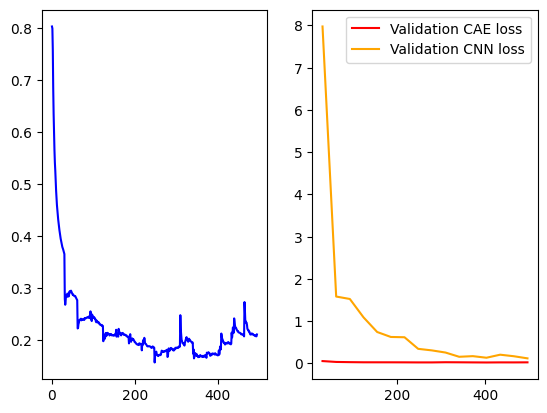

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(model_softmax.loss_list, '-', label='Combined training loss', color='blue')
ax2.plot((np.arange(model_softmax.training_epochs)+1)*31, model_softmax.val_losses_cae, '-', label='Validation CAE loss', color='red')
ax2.plot((np.arange(model_softmax.training_epochs)+1)*31, model_softmax.val_losses_clust, '-', label='Validation CNN loss', color='orange')
plt.legend()
plt.show()

In [ ]:
pred_labels1 = model_softmax.inference()

# Loop over datasets:
ds_counter = 0
for ds in training_dsid:
    
    ds_imgs = model_softmax.image_data[model_softmax.dataset_labels==ds]
    curr_labels = pred_labels1[model_softmax.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels1):
        tmp = np.mean(ds_imgs[curr_labels==cluster], axis=0)
        cluster_ion_images.append(tmp)
    fig, axs = plt.subplots(ncols=len(set(pred_labels1)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1


### Distance of embeddings of same ions

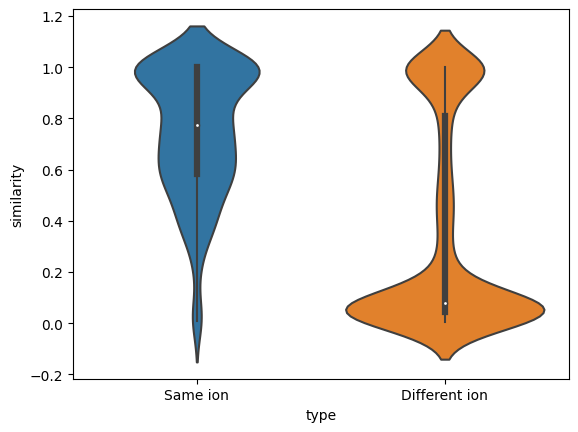

In [70]:
same_ion_similarity(model_softmax)

### Adduct similarity

In [124]:
def adduct_similarity(model, separator='+'):
    # compute centroids
    ion_centroids = []
    centroid_labels = []
    for i in set(model.ion_labels):
        if len(embeddings[model.ion_labels==i]) > 1:
            a = embeddings[model_softmax.ill_int==1]
            ion_centroids.append(a.sum(axis=0)/a.shape[0])
            centroid_labels.append(i)
        else:
            ion_centroids.append(embeddings[model.ion_labels==i][0])
            centroid_labels.append(i)
    # Compute adduct similarity:
    molecules = np.array([x.split(separator)[0] for x in centroid_labels])
    ion_centroids = np.stack(ion_centroids)
    
    same_similarities = []
    for mol in set(molecules):
        # Only if there exists multiple adducts
        if sum(molecules==mol) > 1:
            # Compute mean similarity between adducts
            a = pairwise_kernels(ion_centroids[molecules==mol], metric='cosine')
            np.fill_diagonal(a, val=0)
            same_similarities.append(a.sum()/(binom(a.shape[0], 2)*2))
            
    # Sample different ions
    different_similarities = []
    for i in range(5000):
        samples = np.random.randint(0, high=ion_centroids.shape[0], size=2)
        if molecules[samples[0]] != molecules[samples[1]]:
            a = pairwise_kernels(embeddings[samples], metric='cosine')
            different_similarities.append(a[1,0])
    
    final_df = pd.concat([pd.DataFrame({'type': 'Same molecule', 'similarity': same_similarities}), 
                          pd.DataFrame({'type': 'Different molecule', 'similarity': different_similarities})])
    sns.violinplot(final_df, x='type', y='similarity')
    plt.show()
    

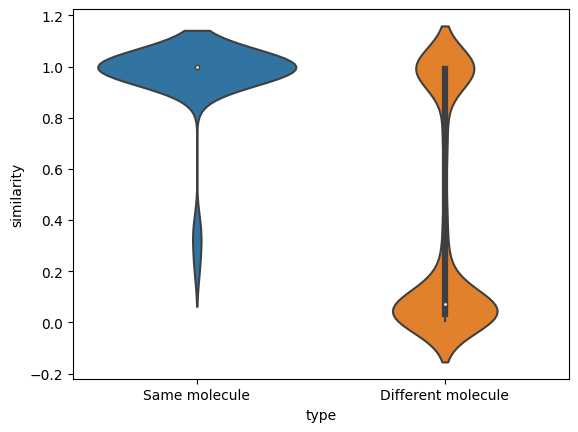

In [125]:
adduct_similarity(model_softmax)

In [121]:
model = model_softmax

ion_centroids = []
centroid_labels = []
for i in set(model.ion_labels):
    if len(embeddings[model.ion_labels==i]) > 1:
        a = embeddings[model_softmax.ill_int==1]
        ion_centroids.append(a.sum(axis=0)/a.shape[0])
        centroid_labels.append(i)
    else:
        ion_centroids.append(embeddings[model.ion_labels==i][0])
        centroid_labels.append(i)
# Compute adduct similarity:
molecules = np.array([x.split('+')[0] for x in centroid_labels])
ion_centroids = np.stack(ion_centroids)
ion_centroids

array([[0.18558683, 0.0098036 , 0.08869926, ..., 0.00245567, 0.20175737,
        0.00529234],
       [0.18558683, 0.0098036 , 0.08869926, ..., 0.00245567, 0.20175737,
        0.00529234],
       [0.18558683, 0.0098036 , 0.08869926, ..., 0.00245567, 0.20175737,
        0.00529234],
       ...,
       [0.18558683, 0.0098036 , 0.08869926, ..., 0.00245567, 0.20175737,
        0.00529234],
       [0.18558683, 0.0098036 , 0.08869926, ..., 0.00245567, 0.20175737,
        0.00529234],
       [0.18558683, 0.0098036 , 0.08869926, ..., 0.00245567, 0.20175737,
        0.00529234]], dtype=float32)

In [110]:
ion_centroids

[array([0.18558683, 0.0098036 , 0.08869926, 0.23277116, 0.2736338 ,
        0.00245567, 0.20175737, 0.00529234], dtype=float32),
 array([0.18558683, 0.0098036 , 0.08869926, 0.23277116, 0.2736338 ,
        0.00245567, 0.20175737, 0.00529234], dtype=float32),
 array([0.18558683, 0.0098036 , 0.08869926, 0.23277116, 0.2736338 ,
        0.00245567, 0.20175737, 0.00529234], dtype=float32),
 array([0.18558683, 0.0098036 , 0.08869926, 0.23277116, 0.2736338 ,
        0.00245567, 0.20175737, 0.00529234], dtype=float32),
 array([0.18558683, 0.0098036 , 0.08869926, 0.23277116, 0.2736338 ,
        0.00245567, 0.20175737, 0.00529234], dtype=float32),
 array([0.18558683, 0.0098036 , 0.08869926, 0.23277116, 0.2736338 ,
        0.00245567, 0.20175737, 0.00529234], dtype=float32),
 array([0.18558683, 0.0098036 , 0.08869926, 0.23277116, 0.2736338 ,
        0.00245567, 0.20175737, 0.00529234], dtype=float32),
 array([[0.04394729, 0.7667534 , 0.02725559, 0.05279311, 0.053346  ,
         0.00378713, 0.04556

## ReLU

In [18]:
# Relu is a real bitch. Super easy to get too high gradients resulting in nans
model_relu = DeepClustering(
                        images=training_data,
                        dataset_labels=training_datasets,
                        ion_labels=training_ions,
                        num_cluster=8,
                        initial_upper=93,
                        initial_lower=37,
                        upper_iteration=1.5,
                        lower_iteration=1.5,
                        dataset_specific_percentiles=True,
                        random_flip=True,
                        knn=True, k=5,
                        lr=0.0001, batch_size=100,
                        pretraining_epochs=2,
                        training_epochs=16,
                        cae_encoder_dim=20,
                        use_gpu=True,
                        activation='relu',
                        overweight_cae=0.5,
                        clip_gradients=.05,
                        weight_decay=1e-2,
                        cnn_dropout=.2,
                        random_seed=np.random.randint(0, 10000)
                            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [19]:
model_relu.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 00 Training Loss: 0.100688 | Validation Loss: 0.025919
Pretraining Epoch: 01 Training Loss: 0.026034 | Validation Loss: 0.023056
Epoch: 00 | CAE-Loss: 0.034088 | CNN-Loss: 0.421076 | Total loss: 0.438120
  * Val:  | CAE-Loss: 0.029090 | CNN-Loss 22.780773
Epoch: 01 | CAE-Loss: 0.033831 | CNN-Loss: 0.206548 | Total loss: 0.223463
  * Val:  | CAE-Loss: 0.030906 | CNN-Loss 5.038912
Epoch: 02 | CAE-Loss: 0.032559 | CNN-Loss: 0.095676 | Total loss: 0.111955
  * Val:  | CAE-Loss: 0.031523 | CNN-Loss 2.188010
Epoch: 03 | CAE-Loss: 0.032529 | CNN-Loss: 0.111242 | Total loss: 0.127507
  * Val:  | CAE-Loss: 0.031087 | CNN-Loss 1.621699
Epoch: 04 | CAE-Loss: 0.031495 | CNN-Loss: 0.084760 | Total loss: 0.100508
  * Val:  | CAE-Loss: 0.029069 | CNN-Loss 1.220261
Epoch: 05 | CAE-Loss: 0.030632 | CNN-Loss: 0.088063 | Total loss: 0.103379
  * Val:  | CAE-Loss: 0.029543 | CNN-Loss 0.644137
Epoch: 06 | CAE-Loss: 0.029858 | CNN-L

0

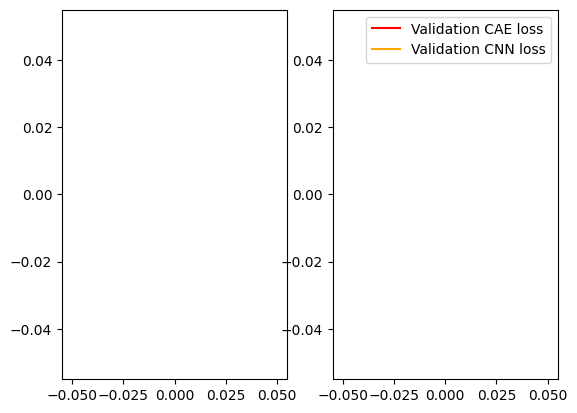

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(model_relu.loss_list, '-', label='Combined training loss', color='blue')
ax2.plot((np.arange(model_relu.training_epochs)+1)*31, model_relu.val_losses_cae, '-', label='Validation CAE loss', color='red')
ax2.plot((np.arange(model_relu.training_epochs)+1)*31, model_relu.val_losses_clust, '-', label='Validation CNN loss', color='orange')
plt.legend()
plt.show()

## Sigmoid

In [11]:
model_sigmoid = DeepClustering(
                                images=training_data,
                                dataset_labels=training_datasets,
                                ion_labels=training_ions,
                                num_cluster=8,
                                initial_upper=93,
                                initial_lower=37,
                                upper_iteration=1.5,
                                lower_iteration=1.5,
                                dataset_specific_percentiles=True,
                                random_flip=True,
                                knn=True, k=5,
                                lr=0.0001, batch_size=128,
                                pretraining_epochs=11,
                                training_epochs=16,
                                cae_encoder_dim=20,
                                use_gpu=True,
                                activation='sigmoid',
                                random_seed=1225
                            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [ ]:
model_sigmoid.train()